In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [14]:
!unzip PlantVillage.zip


Archive:  PlantVillage.zip
replace PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
replace PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: PlantVillage/Potato___Early_blight/320be8ee-2f9a-48f2-86fa-1c1d993a2fe2___RS_Early.B 8186.JPG  
  inflating: PlantVillage/Potato___Early_blight/32c3bd85-3b12-4051-9185-12d39caaf94f___RS_Early.B 6684.JPG  
  inflating: PlantVillage/Potato___Early_blight/33019904-ac3b-4083-a192-ce4092758ddd___RS_Early.B 8344.JPG  
  inflating: PlantVillage/Potato___Early_blight/334fd34b-f4aa-4cc2-9ac9-8b85df65b96c___RS_Early.B 6773.JPG  
  inflating: PlantVillage/Potato___Early_blight/336e5156-8947-46a7-a6fb-e993255d9091___RS_Early.B 8085.JPG  
  inflating: PlantVillage/Potato___

In [12]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [15]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [20]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(image_batch[0].shape)

(32, 256, 256, 3)
[0 0 0 0 1 0 0 1 0 0 2 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1]
(256, 256, 3)


In [17]:
len(dataset)

68

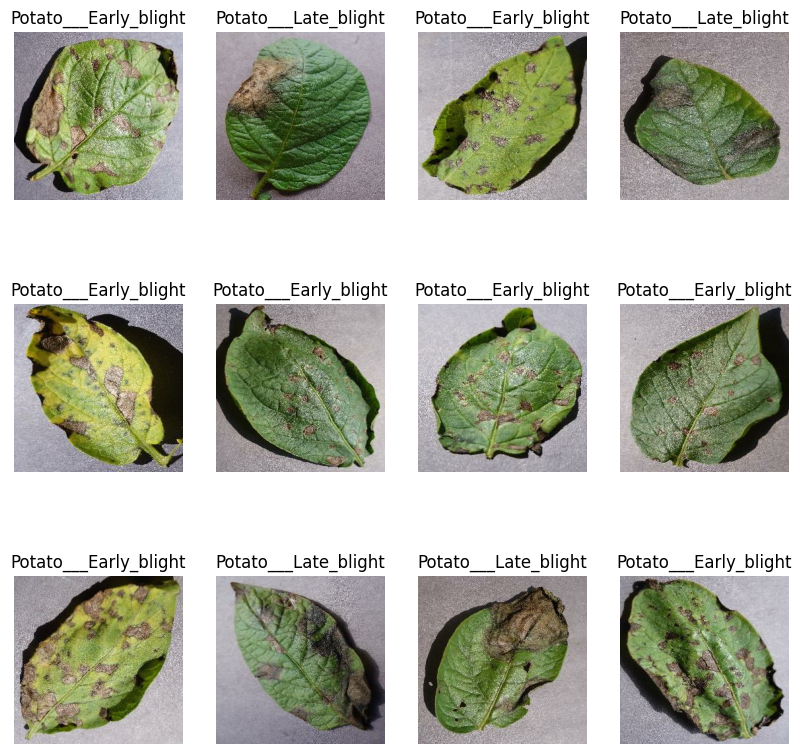

In [21]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [22]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train_ds = dataset.take(54)
len(train_ds)

54

In [24]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [26]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [27]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [28]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [29]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [30]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
len(train_ds)


54

In [33]:
len(val_ds)


6

In [34]:
len(test_ds)

8

In [35]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [37]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [38]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 27s 312ms/step - loss: 0.9064 - accuracy: 0.4884 - val_loss: 0.8471 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 16s 291ms/step - loss: 0.7143 - accuracy: 0.6753 - val_loss: 0.3782 - val_accuracy: 0.8490
Epoch 3/50
54/54 [==============================] - 18s 327ms/step - loss: 0.2910 - accuracy: 0.8883 - val_loss: 0.2022 - val_accuracy: 0.9479
Epoch 4/50
54/54 [==============================] - 16s 286ms/step - loss: 0.2152 - accuracy: 0.9109 - val_loss: 0.3175 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 16s 293ms/step - loss: 0.1216 - accuracy: 0.9589 - val_loss: 0.1006 - val_accuracy: 0.9531
Epoch 6/50
54/54 [==============================] - 15s 281ms/step - loss: 0.1479 - accuracy: 0.9485 - val_loss: 0.2285 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 15s 276ms/step - loss: 0.1021 - accuracy: 0.9589 - val_loss: 0.1091 - val_accuracy: 0.9479

In [43]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 26ms/step - loss: 0.1346 - accuracy: 0.9570


In [44]:
scores

[0.13464660942554474, 0.95703125]

In [45]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
history.history['loss'][:5]

[0.9063714146614075,
 0.7142500877380371,
 0.2910133898258209,
 0.21518447995185852,
 0.12159288674592972]

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

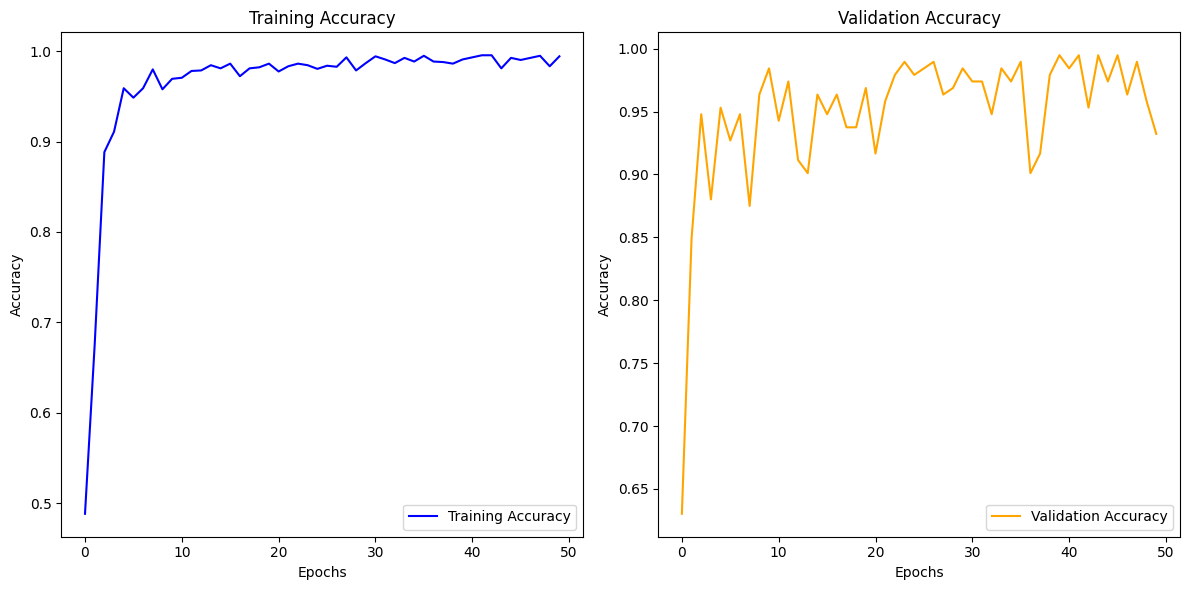

In [49]:
plt.figure(figsize=(12, 6))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy', color='orange')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()  # Adjust layout to prevent overlapping





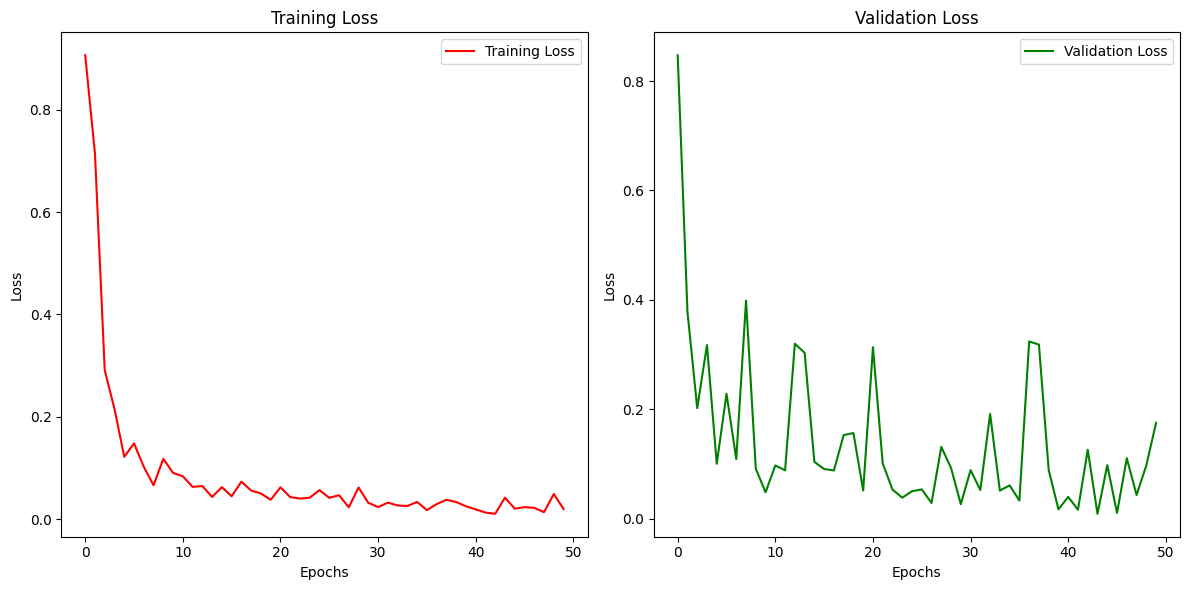

In [50]:
plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label='Training Loss', color='red')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', color='green')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 316ms/step
predicted label: Potato___Late_blight


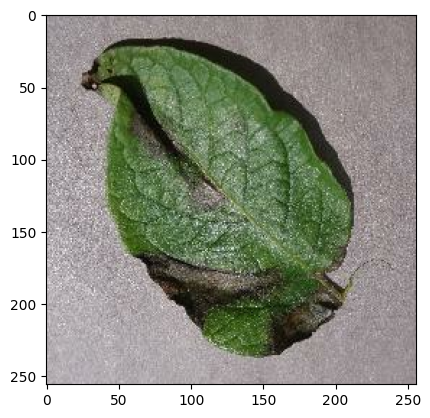

In [51]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


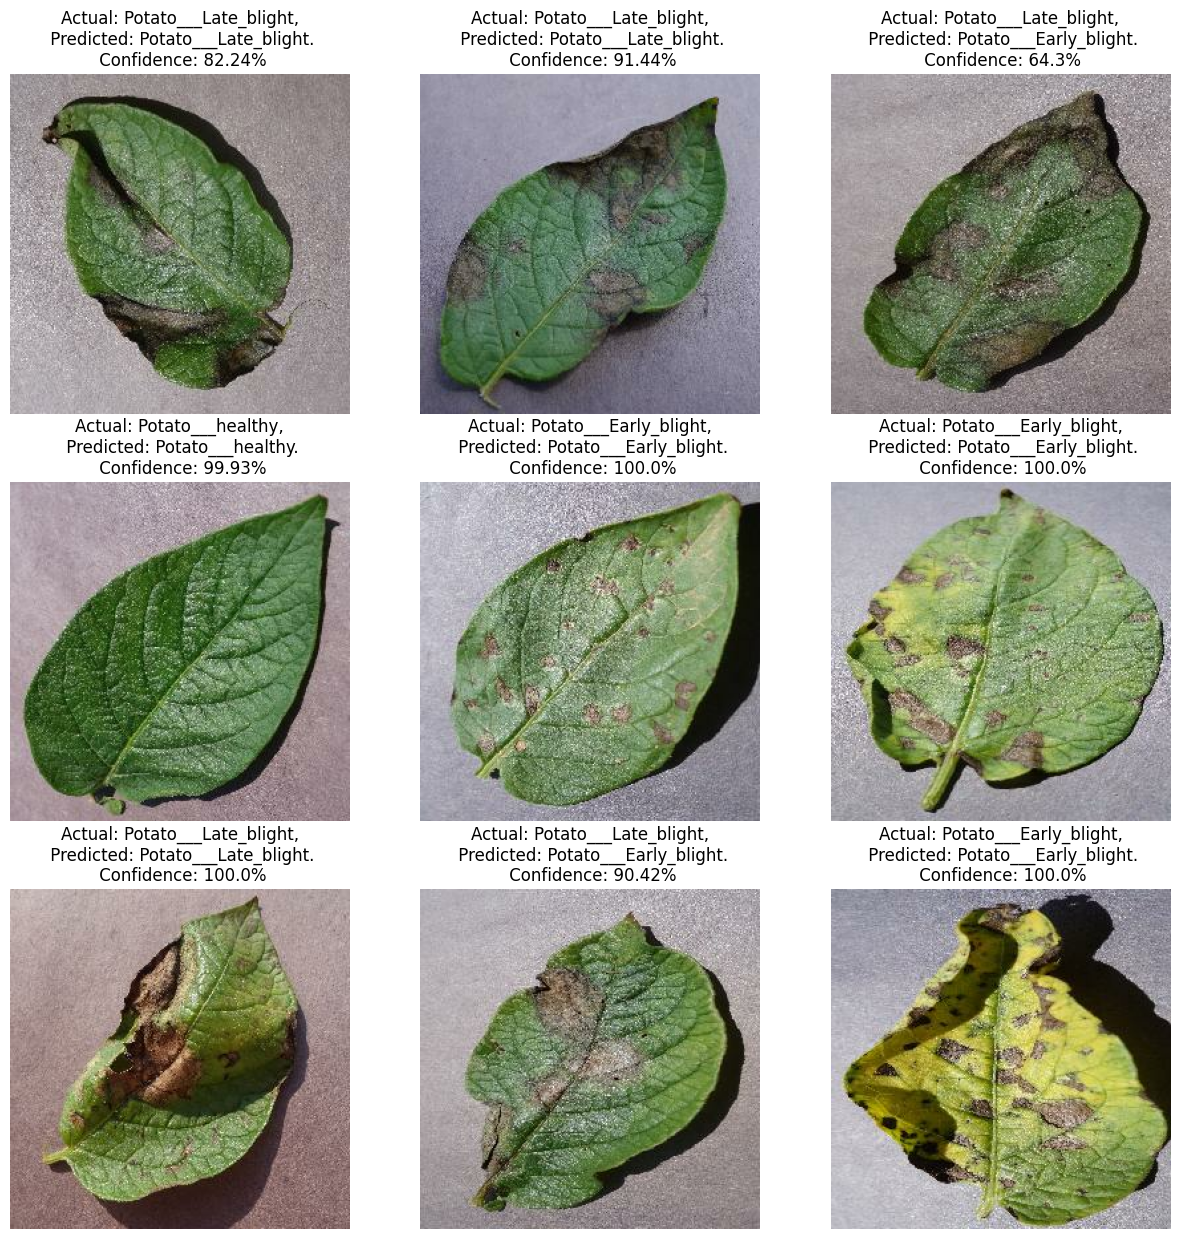

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [56]:
model.save('my_model.keras')

1/1 [==============================] - 0s 29ms/step


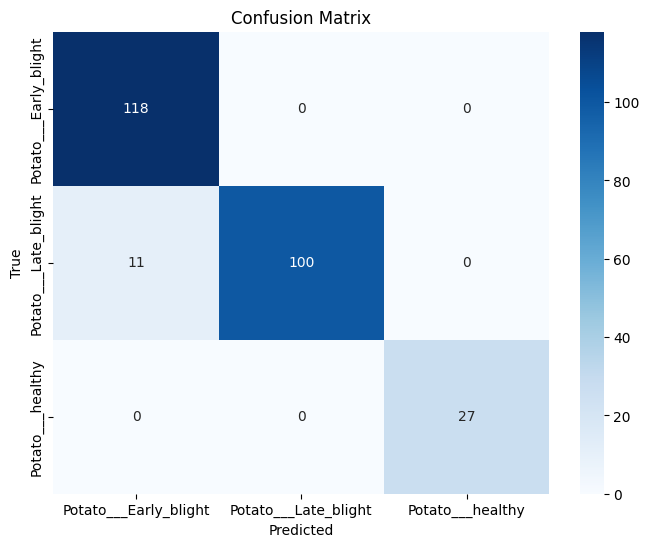

In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ...

# Extract true labels and predicted labels for the test set
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert class indices to class labels
true_labels = [class_names[label] for label in true_labels]
predicted_labels = [class_names[label] for label in predicted_labels]

# Plot Confusion Matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names)
